In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
nltk.download('stopwords')
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

[nltk_data] Error loading stopwords: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


In [2]:
dataset = pd.read_csv("datasets/toxic_comments_1.csv",nrows=4000)

In [3]:
dataset = dataset[["comment_text","toxic"]]

In [4]:
#cleaning the text
dataset.columns = ["comment","toxic"]
dataset["comment"] = dataset["comment"].str.replace("\n"," ")

In [5]:
bag_of_words = []
import re
for i in range(0,4000):
    words = re.sub('[^a-zA-Z]',' ',dataset["comment"][i])
    words = words.lower().split()
    words = [word for word in words if not word in set(stopwords.words("english"))]
    sentence = ' '.join(words)
    bag_of_words.append(sentence)

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,LSTM,Embedding
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer

In [7]:
tokenizer = Tokenizer(num_words=30000)

In [8]:
tokenizer.fit_on_texts(np.array(bag_of_words))

In [11]:
X = tokenizer.texts_to_sequences(np.array(bag_of_words))
X = sequence.pad_sequences(X,maxlen=50)

In [12]:
y = dataset["toxic"].values
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=0)

In [19]:
model = Sequential()
model.add(Embedding(30000,100))
model.add(LSTM(100,dropout=0.2,recurrent_dropout=0.2))
model.add(Dense(1,activation='sigmoid'))

In [20]:
#functions to calculate recall,precision and f1_score
from tensorflow.keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy',f1_m,precision_m, recall_m])

In [21]:
history = model.fit(X_train,y_train,batch_size=45,epochs=5,verbose=2,validation_data=(X_test,y_test))

Train on 3200 samples, validate on 800 samples
Epoch 1/5
3200/3200 - 27s - loss: 0.3829 - accuracy: 0.8913 - f1_m: 0.0021 - precision_m: 0.0013 - recall_m: 0.0046 - val_loss: 0.3040 - val_accuracy: 0.9038 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 2/5
3200/3200 - 18s - loss: 0.2383 - accuracy: 0.9119 - f1_m: 0.1906 - precision_m: 0.3472 - recall_m: 0.1396 - val_loss: 0.1980 - val_accuracy: 0.9350 - val_f1_m: 0.4996 - val_precision_m: 0.7917 - val_recall_m: 0.4012
Epoch 3/5
3200/3200 - 18s - loss: 0.0724 - accuracy: 0.9772 - f1_m: 0.8442 - precision_m: 0.9104 - recall_m: 0.8075 - val_loss: 0.1976 - val_accuracy: 0.9413 - val_f1_m: 0.5833 - val_precision_m: 0.7731 - val_recall_m: 0.5000
Epoch 4/5
3200/3200 - 18s - loss: 0.0270 - accuracy: 0.9906 - f1_m: 0.9435 - precision_m: 0.9660 - recall_m: 0.9378 - val_loss: 0.2339 - val_accuracy: 0.9400 - val_f1_m: 0.5828 - val_precision_m: 0.7574 - val_recall_m: 0.5144
Epoch 5/5
3200/3200 - 18s - loss: 0.0

In [22]:
from sklearn.metrics import roc_curve


In [23]:
y_pred = model.predict(X_test)

In [30]:
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred)

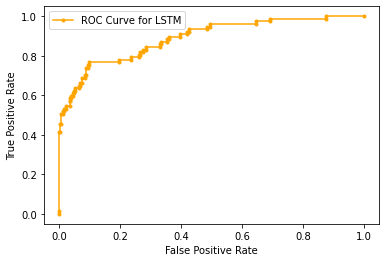

In [31]:
import matplotlib.pyplot as plt
plt.plot(fpr_keras, tpr_keras, marker='.', label='ROC Curve for LSTM',color='orange')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

In [32]:
y_pred[y_pred > 0.5]

array([0.786731  , 0.9945229 , 0.9953556 , 0.98998356, 0.7722433 ,
       0.9979227 , 0.9848771 , 0.9655132 , 0.95116675, 0.5166136 ,
       0.6776186 , 0.98912024, 0.8479865 , 0.9970005 , 0.9979651 ,
       0.5922169 , 0.9993592 , 0.96204853, 0.9745607 , 0.99675924,
       0.9975781 , 0.9988525 , 0.7663258 , 0.99202627, 0.99736917,
       0.91850984, 0.9988568 , 0.99817014, 0.960987  , 0.81697494,
       0.78795147, 0.7679913 , 0.825558  , 0.99903023, 0.7113161 ,
       0.99933666, 0.89119405, 0.99920565, 0.9992993 , 0.96105987,
       0.990888  , 0.67487097, 0.9990081 , 0.9212244 , 0.96618915,
       0.99666566, 0.99879754, 0.98891044, 0.99140817, 0.9982412 ,
       0.95199937], dtype=float32)

In [33]:
#al
results = []
for result in y_pred:
    if result > 0.5:
        results.append(1)
    else:
        results.append(0)
results = np.array(results)

In [34]:
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, results)

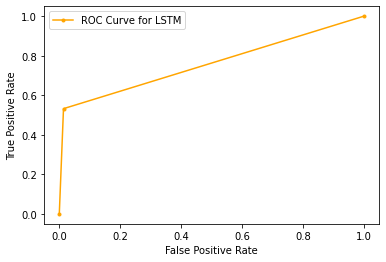

In [35]:
import matplotlib.pyplot as plt
plt.plot(fpr_keras, tpr_keras, marker='.', label='ROC Curve for LSTM',color='orange')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()